<a href="https://colab.research.google.com/github/KillerStrike17/10DaysofMLChallenge/blob/master/Day8/Day8_Multiclass_Classification_Using_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day8

## Problem Statement

## Importing Libraries

In [0]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth



auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'",
strategy = tf.distribute.experimental.TPUStrategy(resolver)
with strategy.scope():
  model = mymodel() fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
# Summoning the Gods
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation,Input
from tensorflow.keras.layers import Embedding,LSTM,Bidirectional
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras import utils
import matplotlib.pyplot as plt

In [0]:
#Setting the Tensorflow Environment
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.3.97.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.3.97.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [0]:
!pip install -q kaggle

In [0]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

## Data Loading

In [0]:
!kaggle datasets list -s consumer

ERROR! Session/line number was not unique in database. History logging moved to new session 60
ref                                               title                                              size  lastUpdated          downloadCount  
------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
datafiniti/consumer-reviews-of-amazon-products    Consumer Reviews of Amazon Products                16MB  2019-05-20 00:38:59          14464  
cfpb/us-consumer-finance-complaints               US Consumer Finance Complaints                     84MB  2019-11-14 05:52:29           9770  
uciml/restaurant-data-with-consumer-ratings       Restaurant Data with Consumer Ratings              39KB  2017-09-27 20:46:37           7304  
archaeocharlie/comcastcomplaints                  Comcast Consumer Complaints                         3MB  2019-11-17 23:30:39           1747  
safegraph/visit-patterns-by-census-block-

In [0]:
!kaggle datasets download cfpb/us-consumer-finance-complaints/comsumer_complaints.csv

 90% 76.0M/84.5M [00:03<00:00, 32.7MB/s]
100% 84.5M/84.5M [00:03<00:00, 24.1MB/s]


In [0]:
!unzip us-consumer-finance-complaints.zip

Archive:  us-consumer-finance-complaints.zip
  inflating: consumer_complaints.csv  
  inflating: database.sqlite         


In [0]:
train_set = pd.read_csv('consumer_complaints.csv',usecols=('product','consumer_complaint_narrative'),dtype={'consumer_complaint_narrative': object})

In [0]:
train_set=train_set[train_set['consumer_complaint_narrative'].notnull()]
print(train_set)

                 product                       consumer_complaint_narrative
190126   Debt collection  XXXX has claimed I owe them {$27.00} for XXXX ...
190135     Consumer Loan  Due to inconsistencies in the amount owed that...
190155          Mortgage  In XX/XX/XXXX my wages that I earned at my job...
190207          Mortgage  I have an open and current mortgage with Chase...
190208          Mortgage  XXXX was submitted XX/XX/XXXX. At the time I s...
...                  ...                                                ...
553084  Credit reporting  XXXX XXXX is reporting incorrectly, payments h...
553085  Credit reporting  Reflecting incorrect payment status. Have been...
553086       Payday loan  I have been paying {$180.00} a month through d...
553090          Mortgage  I recently became aware that Amerisave Mortgag...
553096          Mortgage  Bank of America has demonstrated an on-going l...

[66806 rows x 2 columns]


In [0]:
train_set=train_set[train_set['product'].notnull()]
train_set.reset_index(drop=True,inplace=True)
x_train = train_set.iloc[:, 1].values
y_train = train_set.iloc[:, 0].values
print(y_train)

['Debt collection' 'Consumer Loan' 'Mortgage' ... 'Payday loan' 'Mortgage'
 'Mortgage']


In [0]:
train_set

product                       consumer_complaint_narrative
0       Debt collection  XXXX has claimed I owe them {$27.00} for XXXX ...
1         Consumer Loan  Due to inconsistencies in the amount owed that...
2              Mortgage  In XX/XX/XXXX my wages that I earned at my job...
3              Mortgage  I have an open and current mortgage with Chase...
4              Mortgage  XXXX was submitted XX/XX/XXXX. At the time I s...
...                 ...                                                ...
66801  Credit reporting  XXXX XXXX is reporting incorrectly, payments h...
66802  Credit reporting  Reflecting incorrect payment status. Have been...
66803       Payday loan  I have been paying {$180.00} a month through d...
66804          Mortgage  I recently became aware that Amerisave Mortgag...
66805          Mortgage  Bank of America has demonstrated an on-going l...

[66806 rows x 2 columns]

In [0]:
tokenizer = Tokenizer(num_words= 20000, filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True, split=" ")
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(x_train, maxlen=200)

In [0]:
x_train

array([[   0,    0,    0, ..., 1308,  108,  296],
       [  29,  204,   23, ...,    6,  269,  292],
       [  89,  153,    2, ..., 3715,    7, 2048],
       ...,
       [   0,    0,    0, ...,  171,   66,    1],
       [   4, 1684, 3976, ..., 1097,  429,   68],
       [ 794,    2, 1324, ...,   16,  341,  874]], dtype=int32)

In [0]:
labelencoder_Y = LabelEncoder()
y_train = labelencoder_Y.fit_transform(y_train)
print(y_train)
print(np.unique(y_train, return_counts=True))

[4 1 6 ... 8 6 6]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([ 5711,  3678,  7929, 12526, 17552,   666, 14919,   110,   726,
         861,  2128]))


In [0]:
y_train = utils.to_categorical(y_train, num_classes= 11)
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
# Shuffling the data
np.random.seed(200)
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

In [0]:
# Containing the start and end of a word
index_from=3
start_char = 1
if start_char is not None:
        x_train = [[start_char] + [w + index_from for w in x1] for x1 in x_train]
elif index_from:
        x_train = [[w + index_from for w in x1] for x1 in x_train]

In [0]:
x_train

[[1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  6,
  13,
  437,
  212,
  42,
  3379,
  106,
  11,
  544,
  150,
  15,
  5,
  106,
  11,
  664,
  31,
  8,
  9,
  233,
  2196,
  174,
  11,
  866,
  31,
  5585,
  1347,
  31,
  15,
  150,
  634,
  7,
  10,
  310,
  27,
  581,
  10,
  27,
  13,
  943,
  1609,
  37,
  41,
  11,
  229,
  16,
  4,
  4,
  1139,
  15,
  5,
  106,
  11,
  866,
  31,
  19,
  9,
  233,
  2196,
  174,
  90,
  1481,
  71,
  14,
  559,
  4,
  7,
  183,
  7,
  10,
  27,
  1038,
  168,
  3638,
  24,
  42,
  368,
  4,
  16,
  4,
  8,
  4,
  16,
  4,
  1711,
  15,
  368,
  544,
  150,
  1741,
  664,
  31,
  6,
  13,
  18,
  624,
  11,
  4,
  706,
  20,
  106,
  7,
  10,
  27,
  19,
 

In [0]:
## Selecting words of minimum length
num_words = None
if not num_words:
        num_words = max([max(x1) for x1 in x_train])
        
oov_char = 2
skip_top = 0
# by convention, use 2 as OOV word
# reserve 'index_from' (=3 by default) characters:
# 0 (padding), 1 (start), 2 (OOV)
if oov_char is not None:
        x_train = [[w if (skip_top <= w < num_words) else oov_char for w in x1] for x1 in x_train]
else:
        x_train = [[w for w in x1 if (skip_top <= w < num_words)] for x1 in x_train]
        


In [0]:
# split test and train data
test_split = 0.2
idx = int(len(x_train) * (1 - test_split))
X_train, Y_train = np.array(x_train[:idx]), np.array(y_train[:idx])
X_test, Y_test = np.array(x_train[idx:]), np.array(y_train[idx:])

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(y_train)

(53444, 201)
(53444, 11)
(13362, 201)
(13362, 11)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Model Building

In [0]:
max_features = 20000
maxlen = 201
embedding_dims = 50
filters = 250
kernel_size = 3

In [0]:
model = Sequential()
model.add(Embedding(max_features,embedding_dims,input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(filters,kernel_size,padding='valid',activation='relu',strides=1))
model.add(Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1)))
model.add(GlobalMaxPooling1D())
# We add a vanilla hidden layer:
model.add(Dense(256))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(11))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 201, 50)           1000000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 201, 50)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 199, 250)          37750     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 199, 120)          149280    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 120)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               30976     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

In [0]:
def mymodel():
  input_layer = Input(shape=(maxlen, ))
  x = Embedding(max_features,embedding_dims,input_length=maxlen)(input_layer)
  x = Dropout(0.2)(x)
  x = Conv1D(filters,kernel_size,padding='valid',activation='relu',strides=1)(x)
  x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
  x = GlobalMaxPooling1D()(x)
  x = Dense(256)(x)
  x = Dropout(0.2)(x)
  x = Activation('relu')(x)
  x = Dense(11)(x)
  x = Activation('softmax')(x)
  model = Model(inputs=input_layer, outputs=x)
  model.summary()
  model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
  return model



In [0]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)
with strategy.scope():
  model = mymodel()

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 201)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 201, 50)           1000000   
_________________________________________________________________
dropout_12 (Dropout)         (None, 201, 50)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 199, 250)          37750     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 199, 120)          149280    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 120)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               3097

In [0]:
history = model.fit(X_train, Y_train,
          batch_size=32*8,
          epochs=10,
          validation_data=(X_test, Y_test))

Epoch 1/10
209/209 [==============================] - 14s 68ms/step - accuracy: 0.5010 - loss: 1.3871 - val_accuracy: 0.6943 - val_loss: 0.9304
Epoch 2/10
209/209 [==============================] - 12s 59ms/step - accuracy: 0.7506 - loss: 0.7876 - val_accuracy: 0.7883 - val_loss: 0.6671
Epoch 3/10
209/209 [==============================] - 12s 56ms/step - accuracy: 0.8000 - loss: 0.6356 - val_accuracy: 0.8123 - val_loss: 0.6068
Epoch 4/10
209/209 [==============================] - 11s 55ms/step - accuracy: 0.8270 - loss: 0.5511 - val_accuracy: 0.8283 - val_loss: 0.5532
Epoch 5/10
209/209 [==============================] - 11s 54ms/step - accuracy: 0.8476 - loss: 0.4933 - val_accuracy: 0.8366 - val_loss: 0.5268
Epoch 6/10
209/209 [==============================] - 12s 56ms/step - accuracy: 0.8595 - loss: 0.4555 - val_accuracy: 0.8400 - val_loss: 0.5152
Epoch 7/10
209/209 [==============================] - 12s 55ms/step - accuracy: 0.8681 - loss: 0.4231 - val_accuracy: 0.8395 - val_loss:

In [0]:
#function to plot graphs of accuracy and loss
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


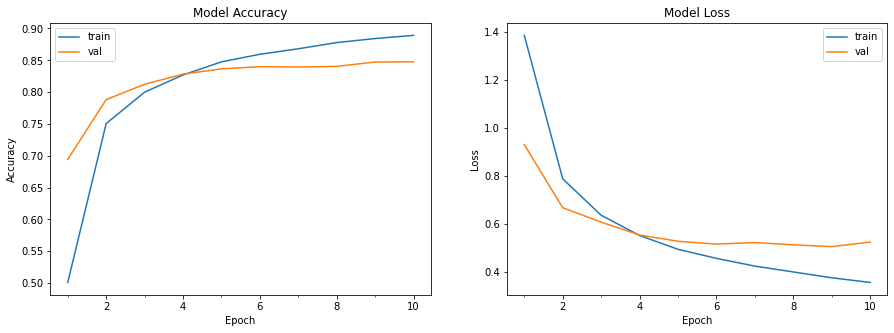

In [0]:
plot_model_history(history)